In [1]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt
import jax
bp.math.set_dt(0.01)

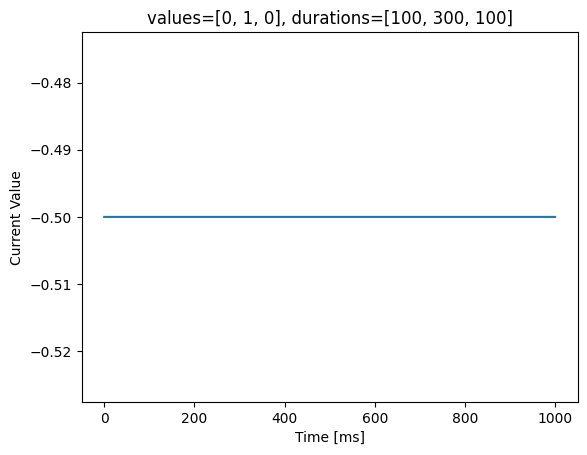

In [51]:
current, duration = bp.inputs.constant_input([(-0.5,1000)])

import numpy as np
import matplotlib.pyplot as plt

def show(current, duration, title):
    ts = np.arange(0, duration, bm.get_dt())
    plt.plot(ts, current)
    plt.title(title)
    plt.xlabel('Time [ms]')
    plt.ylabel('Current Value')
    plt.show()

show(current, duration, 'values=[0, 1, 0], durations=[100, 300, 100]')

# Method1 

In [78]:
class HNa(bp.dyn.INa_HH1952v2):
    def __init__(self,size, g_max=35., phi=5., V_sh=-40.,C=1.,E=55.0,  method='exp_auto'):
        super().__init__(size, g_max=g_max, phi=phi,
                         V_sh=V_sh,method=method)

    def f_p_alpha(self, V):
        temp = V - self.V_sh - 5
        # print('temp=', temp - V,V)
        return 0.1 * temp / (1 - bm.exp(-temp / 10))

    def f_p_beta(self, V):
        return 4.0 * bm.exp(-(V - self.V_sh + 20) / 18)

    
    def m_inf(self,V): 
        return self.f_p_alpha(V)/(self.f_p_alpha(V) +  self.f_p_beta(V))
    
    def current(self,V,C,E):
        return self.g_max *  self.m_inf(V)** 3 * self.q * (E -V)

In [87]:
class HCa(bp.dyn.ICaHT_HM1992):
    def __init__(self,size, g_max=3., V_sh=0.,T=34.,T_base_p=1.,T_base_q=1.,C=1.,E=120.0,  method='exp_auto'):
        # can not directly modify the value of phi_p and phi_q
        super().__init__(size, g_max=g_max,T=T, T_base_p=T_base_p, T_base_q=T_base_q,method=method) 
        
    def f_p_inf(self, V):
        return 1. / (1. + bm.exp(-(V + 57.) / 6.2))

    def f_p_tau(self, V):
        return 1. / (bm.exp(-(V + 132.) / 16.7) +
                 bm.exp((V + 16.8 ) / 18.2)) + 0.612

    def f_q_inf(self, V):
        return 1. / (1. + bm.exp((V + 81.) / 4.))

    def f_q_tau(self, V):
        return bm.where(V >= -80. ,
                    bm.exp(-(V + 22. ) / 10.5) + 28.,
                    bm.exp((V + 467.) / 66.6))
    
    # def dp(self, p, t, V):
    #     # V = -35.804546
    #     # print('M=', jax.debug.print('M_infi:={}',p))
    #     return self.phi_p * (self.f_p_inf(V) - p) / self.f_p_tau(V)
    # def dq(self, q, t, V):
    #     return self.phi_q * (self.f_q_inf(V) - q) / self.f_q_tau(V)


In [88]:
class HH2(bp.dyn.CondNeuGroup):
    def __init__(self, size):
        super(HH2, self).__init__(size,V_initializer=bp.init.Constant(-35.804546))
        # eqn 3a->3e
        self.Na = bp.dyn.SodiumFixed(size, E=55.)
        # ina=bp.dyn.INa_HH1952v2(size, g_max=35., phi=5.0, V_sh=-38.)
        # self.Na.add_elem(ina=ina)
        self.Na.add_elem(ina=HNa(size))
        
        # eqn 3f->3g
        self.K = bp.dyn.PotassiumFixed(size, E=-90.)
        self.K.add_elem(ik=bp.dyn.IK_HH1952v2(size,g_max=9.,phi=5.,V_sh=-24.))
        
        self.IL = bp.dyn.IL(size, E=-65., g_max=0.1)
        
        #eqn 3h->3k
        self.Ca1 = bp.dyn.CalciumFixed(size)
        # ica = bp.dyn.ICaHT_HM1992(size,g_max=3, V_sh=-24.,T=34.,T_base_p=5.,T_base_q=5.)
        # self.Ca1.add_elem(ica=ica)
        self.Ca1.add_elem(ica=HCa(size))#,self.phi_p=1., self.phi_q=1.))
        # if want cross check value of V_sh , use: a.Ca1.ica.V_sh     

In [89]:
model = HH2(1)

<function matplotlib.pyplot.show(close=None, block=None)>

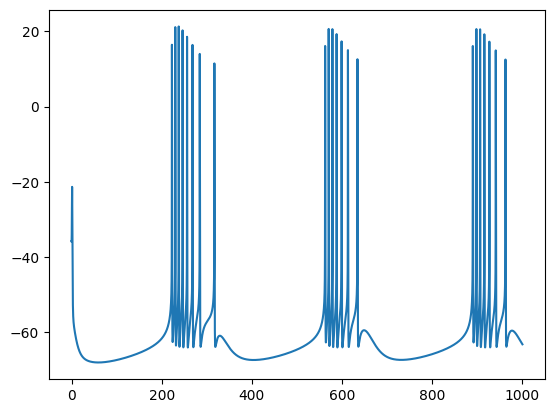

In [90]:
#model.reset()
#[-0.5] current used in paper to replicate figure 1 
# inputs = np.ones(int(1000 / bm.dt))*-0.5
runner = bp.DSRunner(model,monitors=['V'],inputs=[model.input, current, 'iter'],
                         progress_bar=False)

runner.run(1000)
plt.plot(runner.mon.ts, runner.mon['V'])
plt.show

# Method2 

In [70]:
class BurstingHH(bp.dyn.NeuGroup):
  def __init__(self, size, ENa=55., EK=-90., EL=-65, C=1.0, gNa=35.,
               gK=9., gL=0.1, V_th=0., theta=5.0, method='exp_auto'):
    super(BurstingHH, self).__init__(size=size)

    # parameters
    self.ENa = ENa
    self.EK = EK
    self.EL = EL
    self.C = C
    self.gNa = gNa
    self.gK = gK
    self.gL = gL
    self.ECa = 120
    self.gCa = 3
    self.V_th = V_th
    self.theta = theta

    # variables
    self.V = bm.Variable(bm.ones(size) * -35.804546)
    self.h = bm.Variable(bm.ones(size) * 0) #0.004)
    self.n = bm.Variable(bm.ones(size) * 0 ) #0.35) # 8)
    self.H = bm.Variable(bm.ones(size) * 0 ) #1) #0.05)
    self.M = bm.Variable(bm.ones(size) * 0) #1) #0.05)
    self.spike = bm.Variable(bm.zeros(size, dtype=bool))
    self.input = bm.Variable(bm.zeros(size))
    self.t_last_spike = bm.Variable(bm.ones(size) * -1e7)

    # integral
    self.integral = bp.odeint(bp.JointEq([self.dV, self.dh, self.dn, self.dH, self.dM]), method=method)

  def dh(self, h, t, V):
    alpha = 0.07 * bm.exp(-(V + 58) / 20)
    beta = 1 / (bm.exp(-0.1 * (V + 28)) + 1)
    dhdt = alpha * (1 - h) - beta * h
    return self.theta * dhdt

  def dn(self, n, t, V):
    alpha = -0.01 * (V + 34) / (bm.exp(-0.1 * (V + 34)) - 1)
    beta = 0.125 * bm.exp(-(V + 44) / 80)
    dndt = alpha * (1 - n) - beta * n
    return self.theta * dndt

  def dV(self, V, t, h, n, M, H, Iext):
    m_alpha = -0.1 * (V + 35) / (bm.exp(-0.1 * (V + 35)) - 1)
    m_beta = 4 * bm.exp(-(V + 60) / 18)
    m = m_alpha / (m_alpha + m_beta)
    INa = self.gNa * m ** 3 * h * (V - self.ENa)
    IK = self.gK * n ** 4 * (V - self.EK)
    IL = self.gL * (V - self.EL)
    ICa = self.gCa*(M**2)*H*(V - self.ECa)
    # print('Ca=',jax.debug.print('M_infi:={}',ICa))
    dVdt = (- INa - IK -ICa - IL + Iext) / self.C

    return dVdt

  def dM(self,M,t,V):
    M_infi = (1/(1+bm.exp(-(V+57.)/6.2)))
    # print('M_infi=', jax.debug.print('M_infi:={}',M_infi))
    # a = (1/(0.612 + 1/(bm.exp(-(V+132.)/16.7) + bm.exp((V+16.8)/18.2))))*(-M + M_infi)
    # print('M_infi =',  jax.debug.print('M_infi:={}',a) )
    return (1/(0.612 + 1/(bm.exp(-(V+132.)/16.7) + bm.exp((V+16.8)/18.2))))*(-M + M_infi)

  def dH(self,H, t, V):
    H_infi = (1/(1+(bm.exp((V+81.)/4.))))
    # print('H_infi =',  jax.debug.print('H_infi:={}', (1/(28.+bm.exp(-(V+22.)/10.5)))*(-H + H_infi)))
    return bm.where(V <= -80.,
                      (1/bm.exp((V+467.)/66.6))*(-H + H_infi),
                      (1/(28.+bm.exp(-(V+22.)/10.5)))*(-H + H_infi))
    

  def update(self):
    tdi = bp.share.get_shargs()
    _t=tdi.t
    _dt=tdi.dt
    inpt = -0.5   
    V, h, n, H, M = self.integral(self.V, self.h, self.n, self.H, self.M, _t, inpt, _dt)
    self.spike.value = bm.logical_and(self.V < self.V_th, V >= self.V_th)
    self.t_last_spike.value = bm.where(self.spike, _t, self.t_last_spike)
    self.V.value = V
    self.h.value = h
    self.n.value = n
    self.H.value = H
    self.M.value = M
    # print('M=', jax.debug.print('M_infi:={}',H))
    # self.input[:] = 0.

In [71]:
neu = BurstingHH(1)

In [72]:
neu.V,neu.h, neu.H, neu.M, neu.n

(Variable(value=Array([-35.804546]), dtype=float32),
 Variable(value=Array([0.]), dtype=float32),
 Variable(value=Array([0.]), dtype=float32),
 Variable(value=Array([0.]), dtype=float32),
 Variable(value=Array([0.]), dtype=float32))

  0%|          | 0/100000 [00:00<?, ?it/s]

<function matplotlib.pyplot.show(close=None, block=None)>

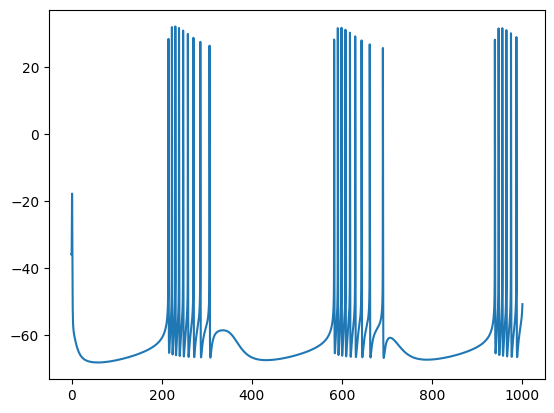

In [73]:
runner = bp.DSRunner(neu,monitors=['V']) #,inputs=[(model.input, -0.5)])
                        # progress_bar=False)

runner.run(1000)
plt.plot(runner.mon.ts, runner.mon['V'])
plt.show